## Data analysis and visualizations

## Part 0: Data Loading and Preparation

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer

f = pd.read_csv("../data/Trips_2018.csv")

### Step 1: Customize the Data Table

In [66]:
print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime'] = pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime'] = pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype'] = pd.Categorical(f['usertype'])
f['gender'] = pd.Categorical(f['gender'])
f['start_station_id'] = pd.Categorical(f['start_station_id'])
f['end_station_id'] = pd.Categorical(f['end_station_id'])

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object


### Step 2: Handle Missing Values

In [67]:
bad_idx = f.index[f.isna().any(axis=1)]
rows_with_na = f[f.isna().any(axis=1)]

# Analyze missing values before dropping
print("=== Missing Values Analysis ===")
print(f"Total rows before dropping NA: {len(f)}")

# Count missing values per column
missing_counts = f.isna().sum()
missing_pct = (f.isna().sum() / len(f) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_pct.values
})

# Filter to show only columns with missing values
missing_df_filtered = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("\nColumns with missing values:")
print(missing_df_filtered.to_string(index=False))

print(f"\nTotal rows with at least one missing value: {len(bad_idx)}")
print(f"Percentage of rows with missing values: {(len(bad_idx)/len(f)*100):.2f}%")

if len(missing_df_filtered) == 0:
    print("\nNo columns have missing values!")

f = f.dropna()
print(f"\nRows after dropping NA: {len(f)}")

=== Missing Values Analysis ===
Total rows before dropping NA: 17548339

Columns with missing values:
          Column  Missing Count  Missing %
start_station_id           2497       0.01
  end_station_id           2497       0.01

Total rows with at least one missing value: 2497
Percentage of rows with missing values: 0.01%

Rows after dropping NA: 17545842

Rows after dropping NA: 17545842


In [68]:
print(f.dtypes)
print(f)

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                 category
start_station_latitude            float64
start_station_longitude           float64
end_station_id                   category
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                         category
birth_year                          int64
gender                           category
dtype: object
          tripduration               starttime                stoptime  \
0                  970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1                  723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2                  496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3                  306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4                  306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642

### Plotting the total pickup for each hour througout the year

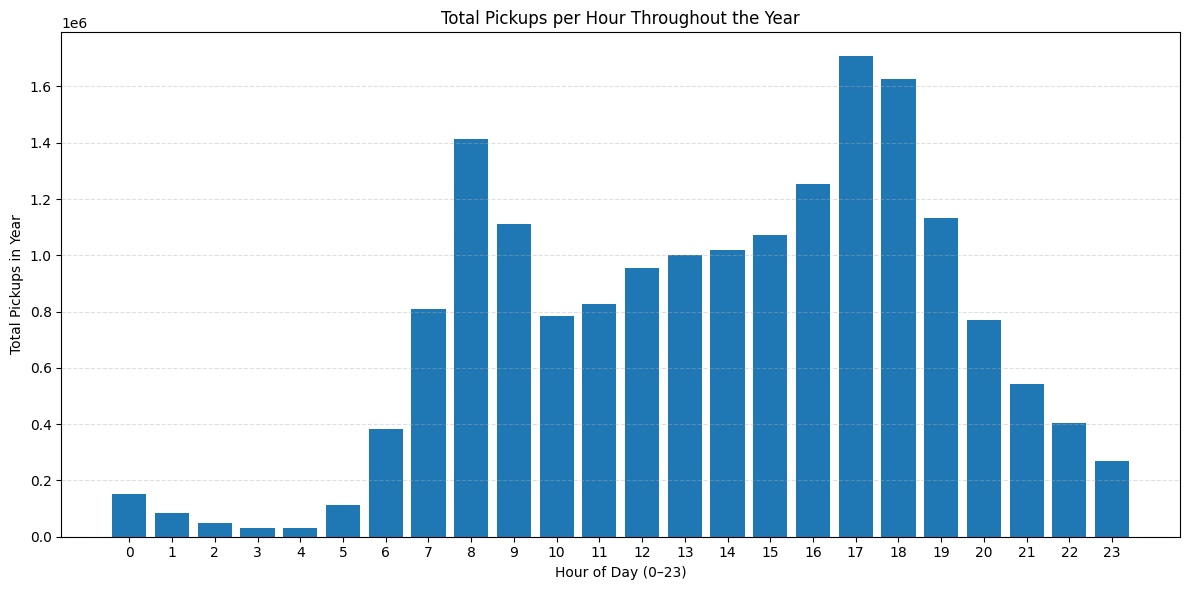

In [69]:
# create an hour column
f['hour_starttime'] = f['starttime'].dt.hour

# Compute total pickups per hour 
hourly_counts = f.groupby('hour_starttime').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# Plot 
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

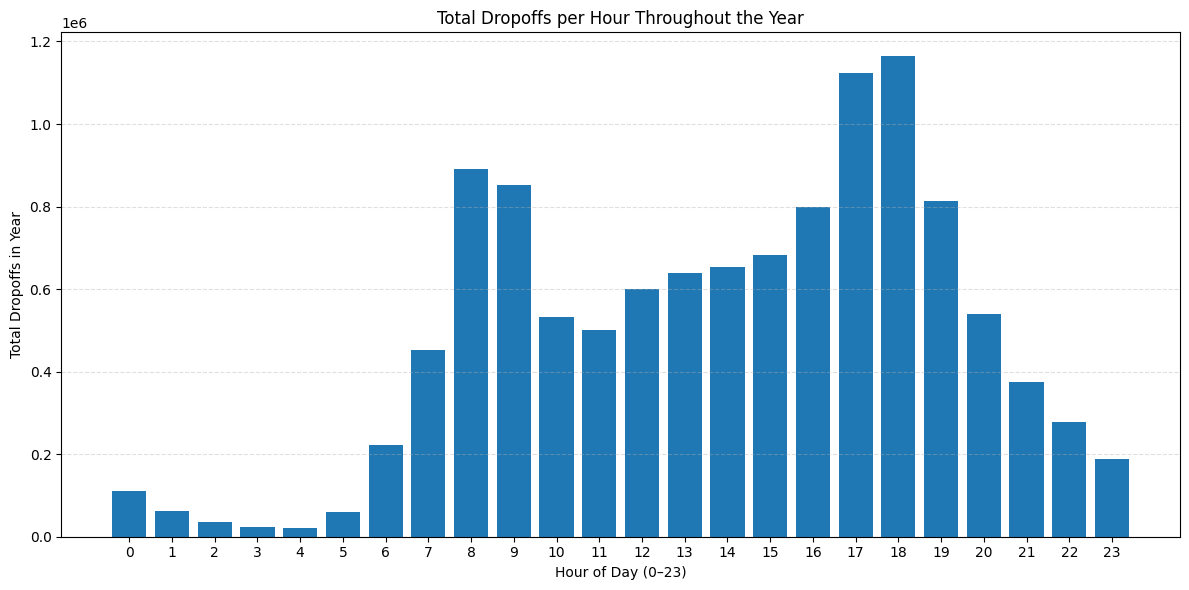

In [104]:
# create an hour column
f['hour_stoptime'] = f['stoptime'].dt.hour

# Compute total pickups per hour 
hourly_counts = f.groupby('hour_stoptime').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# Plot 
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Dropoffs in Year")
plt.title("Total Dropoffs per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Part 1: Prediction Challenge - Tasks 1, 2, and 3

### Task 1: Cluster the stations spatially (≥20 clusters)

Nearby departing stations should be grouped together for better demand prediction at the cluster level.

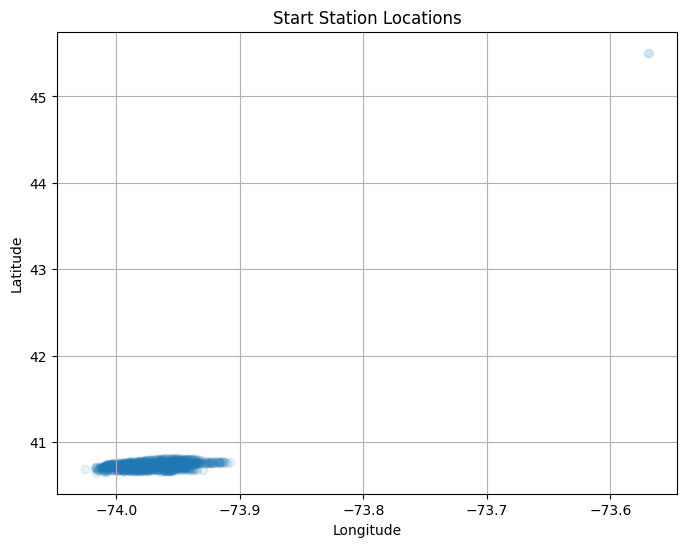

Total unique start stations: 818


In [71]:
# Create a new DataFrame with start station ID and coordinates
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')

plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)
plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

print(f"Total unique start stations: {len(f_cluster)}")

### There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it

In [72]:
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations (outside NYC area):\n", outlier_stations)

Outlier stations (outside NYC area):
        start_station_id  start_station_latitude  start_station_longitude
676612           3488.0               45.506364               -73.569463
714485           3650.0               45.506264               -73.568906


#### Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, so we will remove them from the clustering dataset and the original one

In [73]:
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]
print(f"\nStations after removing outliers: {len(f_cluster)}")


Stations after removing outliers: 816


#### Now, let's use the elbow method to determine the optimal number of clusters (k)

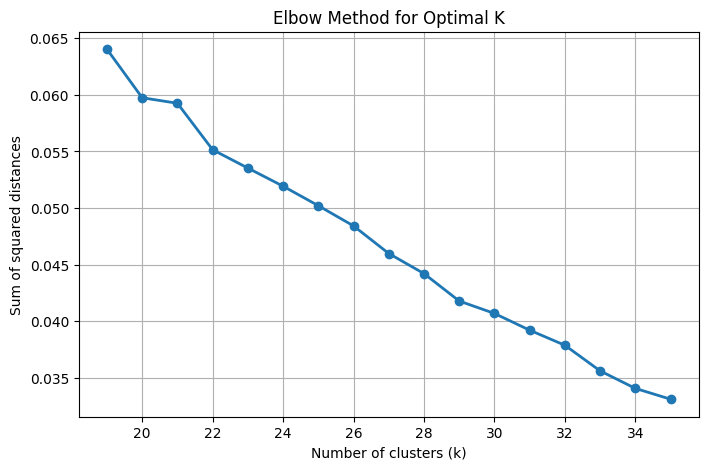

Observation: k=22 appears to be a good choice for the number of clusters.


In [74]:
# Elbow method to determine optimal number of clusters
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

print("Observation: k=22 appears to be a good choice for the number of clusters.")

### We observe that k=22 should be a good choice for the number of clusters.

### Let's run the clustering and look at how the clusters look

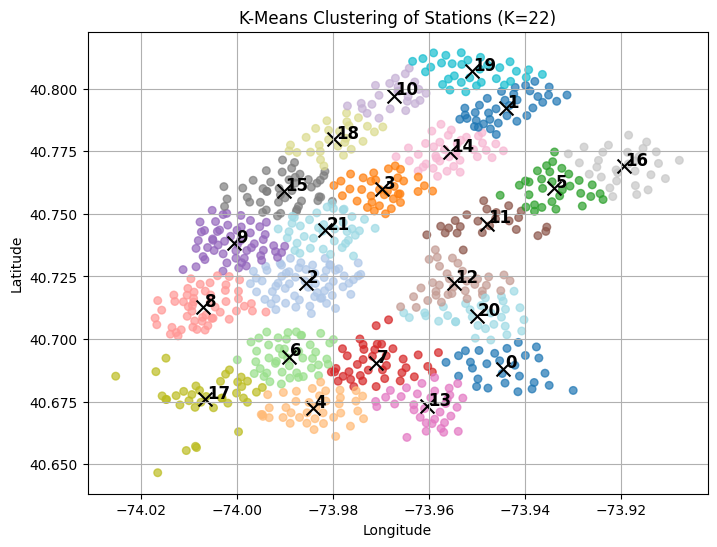

In [75]:
# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Task 2: Build prediction model for next-day hourly demand (24 hours ahead) for selected clusters

- Train on Jan-Oct 2018
- Test on Nov-Dec 2018
- Predict both pickups and dropoffs
- Hourly aggregation

### We want to only look at the clusters that make up the southernmost part of the island of Manhattan

In [76]:
# Focus on southern Manhattan clusters
clusters_to_keep = [2, 8, 9, 15, 21]

# Normalize dtypes before merging
f = f.copy()
f['start_station_id'] = f['start_station_id'].astype(str)
f['end_station_id'] = f['end_station_id'].astype(str)

f_cluster = f_cluster.copy()
f_cluster['start_station_id'] = f_cluster['start_station_id'].astype(str)

stations_to_keep = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_keep),
    'start_station_id'
].unique()

f = f[
    f['start_station_id'].isin(stations_to_keep) |
    f['end_station_id'].isin(stations_to_keep)
].copy()

print(f"Trips in selected Manhattan clusters: {len(f)}")

Trips in selected Manhattan clusters: 11625538


In [77]:
# Add cluster information to main dataframe
f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'cluster': 'start_cluster'}),
    on='start_station_id',
    how='left'
)

f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'start_station_id': 'end_station_id', 'cluster': 'end_cluster'}),
    on='end_station_id',
    how='left'
)

for col in ['start_cluster', 'end_cluster']:
    f[col] = pd.to_numeric(f[col], errors='coerce').astype('Int64')

print(f.head())

   tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

  start_station_id  start_station_latitude  start_station_longitude  \
0             72.0               40.767272               -73.993929   
1             72.0               40.767272               -73.993929   
2             72.0               40.767272               -73.993929   
3             72.0               40.767272               -73.993929   
4             72.0               40.767272               -73.993929   

  end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0          505.0             40.749013             -73.988484   31956   
1         3255.0        

In [78]:
# We want to split the data into hourly time series for each cluster, both for pickups and dropoffs
full_idx = pd.date_range(f['starttime'].min().floor('H'),
                         f['starttime'].max().ceil('H'),
                         freq='H')


def hourly_series_from_trips(df, time_col, cluster_col, cluster_id):
    """Return a single hourly Series (DatetimeIndex, freq='h') for one cluster."""
    s = (df.loc[df[cluster_col] == cluster_id, time_col]
           .dt.floor('H')
           .value_counts()
           .sort_index())
    s.index.name = 'timestamp'
    s = s.reindex(full_idx, fill_value=0).astype(int) # keep rows where there are now pickups/dropoffs
    s.name = f'{cluster_col}_{cluster_id}'
    return s

pickup_series  = {c: hourly_series_from_trips(f, 'starttime', 'start_cluster', c)
                  for c in clusters_to_keep}
dropoff_series = {c: hourly_series_from_trips(f, 'stoptime',  'end_cluster',   c)
                  for c in clusters_to_keep}


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1457575200.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(f['starttime'].min().floor('H'),
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1457575200.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f['starttime'].max().ceil('H'),
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1457575200.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1457575200.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1457575200.py:10: FutureWarning: 'H' is deprecated and will be removed in a future ve

In [79]:
# PICKUPS
pick = (f.loc[f['start_cluster'].isin(clusters_to_keep), ['starttime','start_cluster']]
          .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
          .value_counts(['timestamp','start_cluster'])
          .rename('count')
          .reset_index())

# Build all (timestamp, cluster) combos, then left-join and fill 0
full_pairs = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','start_cluster']
    ).to_frame(index=False)
)

pickup_all = (
    full_pairs.merge(pick, on=['timestamp','start_cluster'], how='left')
              .fillna({'count': 0})
              .astype({'count':'int64'})
              .set_index(['timestamp','start_cluster'])
              .sort_index()
)

# DROPOFFS
drop = (f.loc[f['end_cluster'].isin(clusters_to_keep), ['stoptime','end_cluster']]
          .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
          .value_counts(['timestamp','end_cluster'])
          .rename('count')
          .reset_index())

full_pairs_d = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','end_cluster']
    ).to_frame(index=False)
)

dropoff_all = (
    full_pairs_d.merge(drop, on=['timestamp','end_cluster'], how='left')
                .fillna({'count': 0})
                .astype({'count':'int64'})
                .set_index(['timestamp','end_cluster'])
                .sort_index()
)


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1095759283.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_90364/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))


In [80]:
pickup_all = pickup_all.copy()  

# Extract hour of day and weekday
pickup_all['hour'] = pickup_all.index.get_level_values('timestamp').hour
pickup_all['weekday'] = pickup_all.index.get_level_values('timestamp').weekday

In [81]:
dropoff_all = dropoff_all.copy()

dropoff_all['hour'] = dropoff_all.index.get_level_values('timestamp').hour
dropoff_all['weekday'] = dropoff_all.index.get_level_values('timestamp').weekday


In [82]:
# Create dummy variables for weekday
weekday_dummies_p = pd.get_dummies(pickup_all['weekday'], prefix='weekday')
weekday_dummies_d = pd.get_dummies(dropoff_all['weekday'], prefix='weekday')

# Join back to the original dataframe
pickup_all = pickup_all.join(weekday_dummies_p)
dropoff_all = dropoff_all.join(weekday_dummies_d)

In [83]:
# Change from True/False to 1/0
weekday_cols_p = [col for col in pickup_all.columns if col.startswith('weekday_')]
pickup_all[weekday_cols_p] = pickup_all[weekday_cols_p].astype(int)
weekday_cols_d = [col for col in dropoff_all.columns if col.startswith('weekday_')]
dropoff_all[weekday_cols_d] = dropoff_all[weekday_cols_d].astype(int)


In [84]:
# Change the name of dummy columns to actual days
weekday_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Identify weekday dummy columns
weekday_cols_p = [col for col in pickup_all.columns if col.startswith('weekday_')]
weekday_cols_d = [col for col in dropoff_all.columns if col.startswith('weekday_')]

# Build a renaming dict
rename_dict_p = {f'weekday_{i}': name for i, name in weekday_map.items() if f'weekday_{i}' in weekday_cols_p}
rename_dict_d = {f'weekday_{i}': name for i, name in weekday_map.items() if f'weekday_{i}' in weekday_cols_d}

# Rename the columns
pickup_all = pickup_all.rename(columns=rename_dict_p)
dropoff_all = dropoff_all.rename(columns=rename_dict_d)

In [85]:
# Drop 'weekday' column from both dataframes
pickup_all = pickup_all.drop(columns=['weekday'])
dropoff_all = dropoff_all.drop(columns=['weekday'])

In [86]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res


In [87]:
# Build lagged features for 'count' column with lag of 168 hours (1 week)
pickup_lagged = buildLaggedFeatures(pickup_all, ['count'], lag=168, dropna=True)
dropoff_lagged = buildLaggedFeatures(dropoff_all, ['count'], lag=168, dropna=True)

In [88]:
def my_plot(regr, x, y, size=0.1):

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean absolute error    
    print("Mean Absolute error (MAE): %.2f"% np.mean(abs(regr.predict(x) - y)))
    # The mean squared error
    print("Root Mean squared error: %.2f"
          % np.sqrt(np.mean((regr.predict(x) - y) ** 2)))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
          
    # Plot outputs
    plt.scatter(y, regr.predict(x), color='blue',linewidth=3)
    plt.plot([0, 1200], [0, 1200], color="red")
    plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
    plt.xlabel("observed")
    plt.ylabel("predicted")
    
    plt.show()

In [89]:
# Split into train and test sets
cutoff = pd.Timestamp('2018-10-31 23:59:59')
pickup_train = pickup_lagged[pickup_lagged.index.get_level_values('timestamp') <= cutoff]
pickup_test  = pickup_lagged[pickup_lagged.index.get_level_values('timestamp') >  cutoff]
dropoff_train = dropoff_lagged[dropoff_lagged.index.get_level_values('timestamp') <= cutoff]
dropoff_test  = dropoff_lagged[dropoff_lagged.index.get_level_values('timestamp') >  cutoff]

In [90]:
pickup_train.head()

count  hour  Monday  Tuesday  Wednesday  \
timestamp           start_cluster                                            
2018-01-02 09:00:00 15               190     9       0        1          0   
                    21               212     9       0        1          0   
2018-01-02 10:00:00 2                 92    10       0        1          0   
                    8                 40    10       0        1          0   
                    9                100    10       0        1          0   

                                   Thursday  Friday  Saturday  Sunday  \
timestamp           start_cluster                                       
2018-01-02 09:00:00 15                    0       0         0       0   
                    21                    0       0         0       0   
2018-01-02 10:00:00 2                     0       0         0       0   
                    8                     0       0         0       0   
                    9                     0       0         0       0   

                                   count_lag1  ...  count_lag159  \
timestamp           start_cluster              ...                 
2018-01-02 09:00:00 15                  191.0  ...          16.0   
                    21                  190.0  ...          17.0   
2018-01-02 10:00:00 2                   212.0  ...           5.0   
                    8                    92.0  ...          14.0   
                    9                    40.0  ...           7.0   

                                   count_lag160  count_lag161  count_lag162  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     13.0          31.0           7.0   
                    21                     16.0          13.0          31.0   
2018-01-02 10:00:00 2                      17.0          16.0          13.0   
                    8                       5.0          17.0          16.0   
                    9                      14.0           5.0          17.0   

                                   count_lag163  count_lag164  count_lag165  \
timestamp           start_cluster                                             
2018-01-02 09:00:00 15                     32.0          11.0          13.0   
                    21                      7.0          32.0          11.0   
2018-01-02 10:00:00 2                      31.0           7.0          32.0   
                    8                      13.0          31.0           7.0   
                    9                      16.0          13.0          31.0   

                                   count_lag166  count_lag167  count_lag168  
timestamp           start_cluster                                            
2018-01-02 09:00:00 15                     20.0          11.0          16.0  
                    21                     13.0          20.0          11.0  
2018-01-02 10:00:00 2                      11.0          13.0          20.0  
                    8                      32.0          11.0          13.0  
                    9                       7.0          32.0          11.0  

[5 rows x 177 columns]

Coefficients: 
 [-1.00876765e-01  4.52609900e+00  0.00000000e+00  0.00000000e+00
  4.23400819e-01 -0.00000000e+00 -4.52387210e+00 -1.71688951e+00
  4.30843999e-01  2.73953806e-01  1.33568506e-01  2.75186064e-02
  6.16394694e-01 -3.23662760e-01 -1.11467135e-01 -1.07872383e-01
 -3.03013240e-02 -1.16515101e-01  4.63077033e-02 -3.31467048e-02
  2.71089612e-02  5.81656208e-02  9.03462784e-02 -1.36376251e-02
 -2.11380477e-02 -2.31048923e-02 -2.44550698e-02  1.93881082e-02
 -1.72581357e-02 -2.28326043e-02 -4.42420682e-03  1.89912489e-02
  3.93289860e-02  5.66493684e-03 -4.21242197e-03 -2.86761639e-02
 -2.15769352e-02  9.78571023e-03  1.58306338e-02 -2.39502911e-02
  1.29036416e-02  6.71842901e-03 -3.75723673e-02 -2.87643483e-02
  5.20592445e-02  1.26757551e-02  3.62057650e-03 -8.59082103e-03
 -6.25479585e-02  3.54223454e-02  2.69786849e-02  2.09745358e-02
  6.35222076e-02  1.18170852e-01 -1.34420066e-01 -1.14699552e-02
  1.83891096e-02 -4.79997454e-02 -6.15272458e-02  4.49057799e-02
 -1.32208

/Users/kristinbodvarsdottir/Desktop/Github_repos/ba-group-37/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+07, tolerance: 2.070e+05
  model = cd_fast.enet_coordinate_descent(


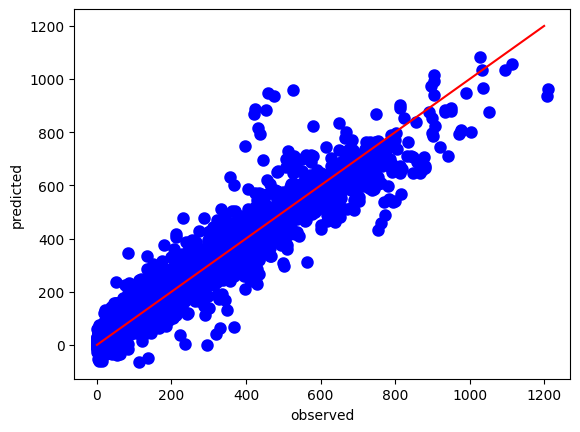

In [91]:
# Let's fit a Lasso regression model on pickups to predict bike_count 
from sklearn.linear_model import Lasso


lasso_pickup = Lasso(alpha=0.1)
lasso_pickup.fit(
    pickup_train.drop(columns=["count"]),
    pickup_train["count"]
)
# Now let's evaluate the model on the test set
my_plot(
    lasso_pickup,
    pickup_test.drop(columns=["count"]),
    pickup_test["count"]
)


=== Cluster 15 ===
Coefficients: 
 [ 2.14581750e-01  1.23278296e+00  6.21468653e-01  0.00000000e+00
  0.00000000e+00 -1.00010738e+00 -2.70908913e+01 -1.82425867e+01
  3.54781899e-01  2.84950128e-01  2.12721531e-01  8.36146157e-02
  4.66521791e-01 -2.15288761e-01 -1.71819551e-01 -4.19240288e-02
 -2.15140441e-02  3.85103532e-02 -3.06625995e-02 -2.29172107e-02
 -7.30856420e-02  1.24759388e-02  3.23929089e-02  2.18771196e-03
 -2.20363768e-02  1.30738735e-02 -1.15451652e-02 -9.45797435e-03
  6.26508878e-03  5.09670634e-03 -1.38915357e-02 -2.95864277e-02
  3.71769265e-02 -1.44288560e-02  3.86178862e-02  7.34952916e-03
 -6.86206242e-03  2.34983284e-02 -4.24286319e-02  1.23091153e-02
  2.48733234e-02 -3.38167000e-02  2.29927303e-03  5.96832358e-03
  6.90533196e-03  1.53733395e-02  7.92291439e-03  1.69075350e-02
  1.31255689e-02 -2.70912758e-02 -1.42753530e-02  2.37629583e-02
 -8.40350612e-04 -1.91465644e-03 -3.98774083e-02  4.57476080e-02
 -1.10010533e-02  1.35687637e-03 -1.36150588e-02 -9.82

/Users/kristinbodvarsdottir/Desktop/Github_repos/ba-group-37/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.826e+06, tolerance: 3.191e+04
  model = cd_fast.enet_coordinate_descent(


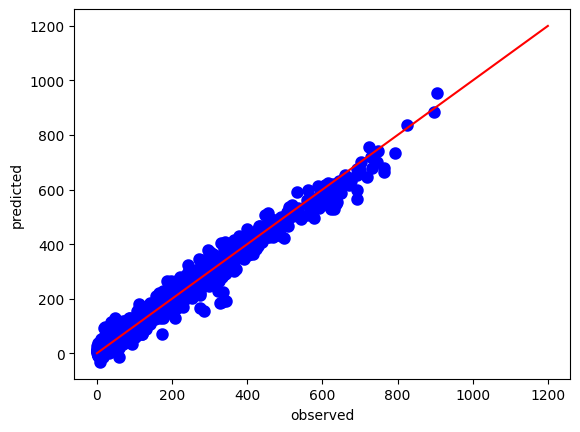


=== Cluster 21 ===
Coefficients: 
 [ 1.14050978e-01  2.34011704e+00  1.79346863e-01  0.00000000e+00
  0.00000000e+00 -2.02350195e+00 -5.61423262e+00 -6.42948319e+00
  3.67562203e-01  1.70302195e-01  2.85840208e-01  2.25760219e-01
  4.71065091e-01  2.20754198e-02 -1.80375068e-01 -3.28465102e-01
 -3.36453827e-02  7.03264880e-02  6.97984722e-02 -4.09694219e-02
 -8.70045039e-02 -5.66037897e-02  2.57022519e-02 -1.67809110e-02
 -5.48502938e-03  4.78258430e-02 -3.05712167e-02  1.67984559e-02
 -3.74404408e-02 -1.40719635e-03  2.08301695e-02  1.99059096e-02
  4.84644453e-03  4.73081909e-02 -3.26694663e-02  6.52945360e-03
 -8.40954256e-04  2.86525461e-03  8.22048005e-03 -8.82844580e-03
 -5.65425684e-03  2.77902581e-02 -3.01460097e-03  2.38429136e-02
 -8.80175493e-03  3.09981289e-03 -7.84887908e-03  4.32352630e-03
  2.79918273e-02 -1.53214621e-02 -1.02876184e-02  8.48880750e-03
  3.09871117e-02 -6.77294254e-03 -4.87053034e-02 -2.40939203e-02
  9.71196340e-02 -1.88488655e-03  4.56712194e-02 -3.29

/Users/kristinbodvarsdottir/Desktop/Github_repos/ba-group-37/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+06, tolerance: 3.891e+04
  model = cd_fast.enet_coordinate_descent(


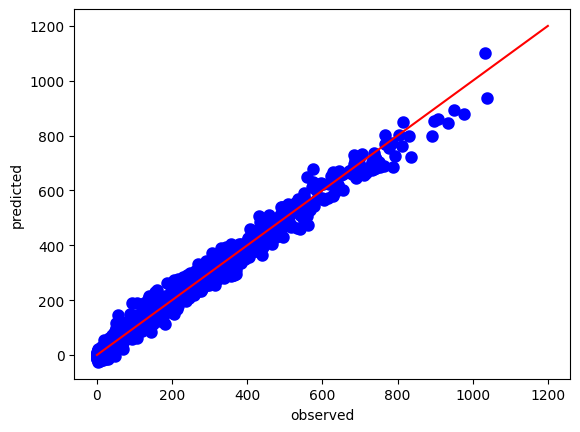


=== Cluster 2 ===
Coefficients: 
 [ 9.67150764e-01 -5.30253903e+00  3.04867813e+00  0.00000000e+00
  5.64449277e+00  2.03562164e+00 -7.51834264e+00 -2.13145627e+01
 -2.58161372e-01  4.25429529e-01  2.95144862e-01  6.87663746e-02
  5.72895276e-01 -4.82293774e-01  3.46357803e-01  6.76664526e-02
 -9.54208408e-02 -1.71892691e-01  2.19970198e-01 -4.61167145e-01
  1.32749120e-01 -3.24555125e-02  2.78330819e-02  8.05204447e-02
 -1.46716989e-01 -4.00681230e-02  4.09793221e-02  4.58096054e-02
 -2.84068743e-02  5.45225570e-04  2.54635229e-02  1.36599003e-02
 -4.22058315e-02 -1.33047664e-02  6.29261236e-02 -7.56297400e-02
  2.77398189e-02 -3.53503322e-02 -3.66803783e-03  5.21266205e-03
 -2.77838012e-02  4.85191248e-02 -2.14697058e-02  2.27155647e-02
  6.45703479e-02 -1.91730735e-02 -1.34450966e-02 -7.54893189e-02
  3.67669008e-02  2.28118507e-02  4.34415267e-03 -5.87130417e-02
  1.02458415e-01 -3.58683580e-03 -6.43766553e-02  5.60145604e-03
 -4.53242578e-02  1.37109372e-01 -5.73564075e-02  1.854

/Users/kristinbodvarsdottir/Desktop/Github_repos/ba-group-37/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+07, tolerance: 3.611e+04
  model = cd_fast.enet_coordinate_descent(


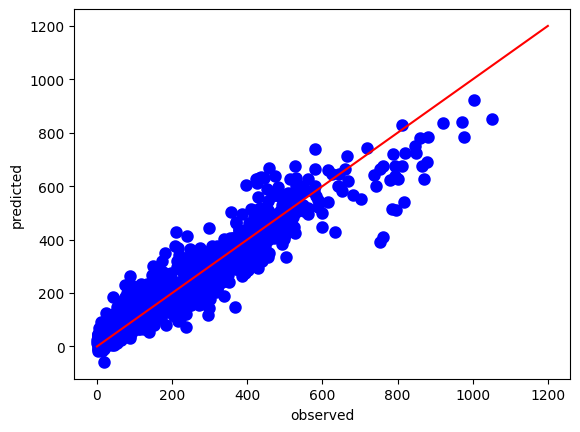


=== Cluster 8 ===
Coefficients: 
 [-8.48377248e-01  3.56398992e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.56606245e-01  0.00000000e+00 -2.24745001e-01
  5.35072802e-01  1.41216444e-01  2.05403708e-02  8.77611264e-03
  6.23760401e-01 -3.09631696e-01 -9.64988398e-02 -1.19480978e-01
  7.81119548e-02 -1.30369605e-01  2.54678398e-02  8.43217060e-02
  6.27851515e-02 -2.83641608e-02  1.59535803e-02 -1.29429806e-02
 -2.33412337e-02 -1.00760487e-02 -1.27467479e-02  1.49755970e-02
  1.87212190e-02 -1.46635928e-03  4.72764004e-02  1.73403166e-02
  1.32560281e-02 -2.17721202e-02 -2.65110126e-02  2.68965839e-03
 -3.05128883e-02  1.09281312e-02  6.80251195e-03 -2.88936020e-02
  1.95742539e-02 -2.52995139e-02  9.48528497e-03 -4.81632982e-02
  9.56026825e-02  1.66575158e-01  3.13952899e-03 -1.14120601e-01
 -1.68189262e-01  1.97930658e-01  1.51326451e-03 -6.09700326e-02
 -1.14603863e-01  3.93753751e-01 -2.14293276e-02 -1.33845289e-01
 -3.02530702e-02  1.38630788e-02 -7.87157965e-02 -1.201

/Users/kristinbodvarsdottir/Desktop/Github_repos/ba-group-37/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.617e+06, tolerance: 3.759e+04
  model = cd_fast.enet_coordinate_descent(


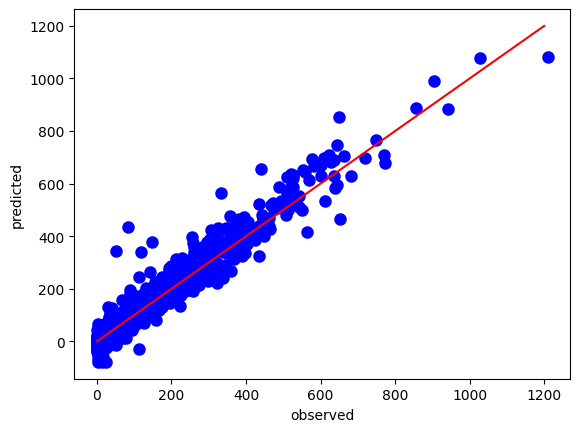


=== Cluster 9 ===
Coefficients: 
 [ 8.49214600e-02  2.18023116e-01 -0.00000000e+00  1.66837510e+00
 -7.98281192e-01 -3.85693745e+00  1.46960606e+00 -0.00000000e+00
  5.51671915e-01  3.93281258e-01  8.24206487e-02  1.03564457e-01
  2.87398259e-01 -4.33315071e-02 -5.91184419e-02 -5.55715045e-02
 -5.87970929e-02  9.35988534e-02 -9.04381504e-02 -6.55319151e-02
  1.15965090e-02  3.40965957e-02  8.91361309e-03  1.43241466e-02
  1.82375691e-02  6.87756889e-02 -5.77302259e-02  1.55713999e-02
 -5.14952133e-02 -1.82142685e-02  2.41348190e-02  6.19995817e-03
 -2.25101147e-02 -5.48574391e-03  1.36971764e-02 -9.44327578e-03
  2.50121738e-02 -8.72390867e-03 -1.13401456e-02 -3.54096677e-03
  2.08179122e-02  2.88353032e-03  6.18370794e-03 -1.48425661e-03
 -5.43348663e-03 -2.14966407e-02  1.55582257e-03  1.34962656e-02
 -2.09423123e-02  1.16901772e-02 -1.93770558e-03  2.44923589e-02
 -7.25854518e-03 -1.34176223e-03 -6.37343093e-03 -6.42013337e-03
  1.38182609e-02 -2.24639228e-02 -6.44978133e-06  2.111

/Users/kristinbodvarsdottir/Desktop/Github_repos/ba-group-37/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.958e+06, tolerance: 5.754e+04
  model = cd_fast.enet_coordinate_descent(


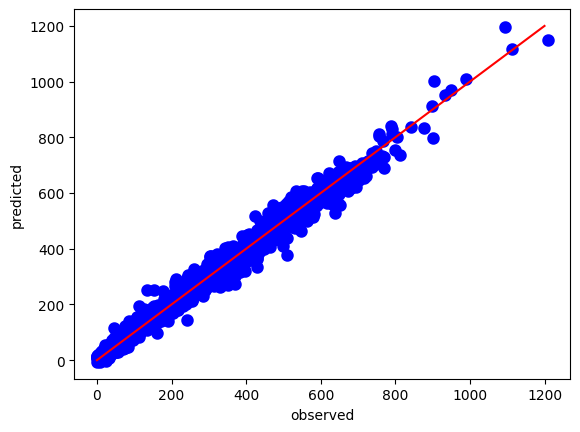

In [92]:
# Let's do this for each cluster separately

clusters = pickup_train.index.get_level_values("start_cluster").unique()

lasso_models = {}   # store models if you want them later

for cluster in clusters:
    # Extract this cluster’s training data
    X_train = pickup_train.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_train = pickup_train.xs(cluster, level="start_cluster")["count"]

    # Extract this cluster’s test data
    X_test  = pickup_test.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_test  = pickup_test.xs(cluster, level="start_cluster")["count"]

    # Fit Lasso model
    #model = Lasso(alpha=0.1)
    lasso_pickup.fit(X_train, y_train)

    # Store model (optional)
    lasso_models[cluster] = lasso_pickup

    # Plot results for this cluster
    print(f"\n=== Cluster {cluster} ===")
    my_plot(
        lasso_pickup,
        X_test,
        y_test
    )

In [93]:
def plotprediction(series, pred_series, metrics, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    plt.legend(loc="upper right")
    plt.grid(True)
    
    ax = plt.gca()
    ax.text(0.01, 0.95, "\n".join(metrics),
            transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75))
    plt.tight_layout()
    # Plot confidence intervals for smoothed values
    plt.show()

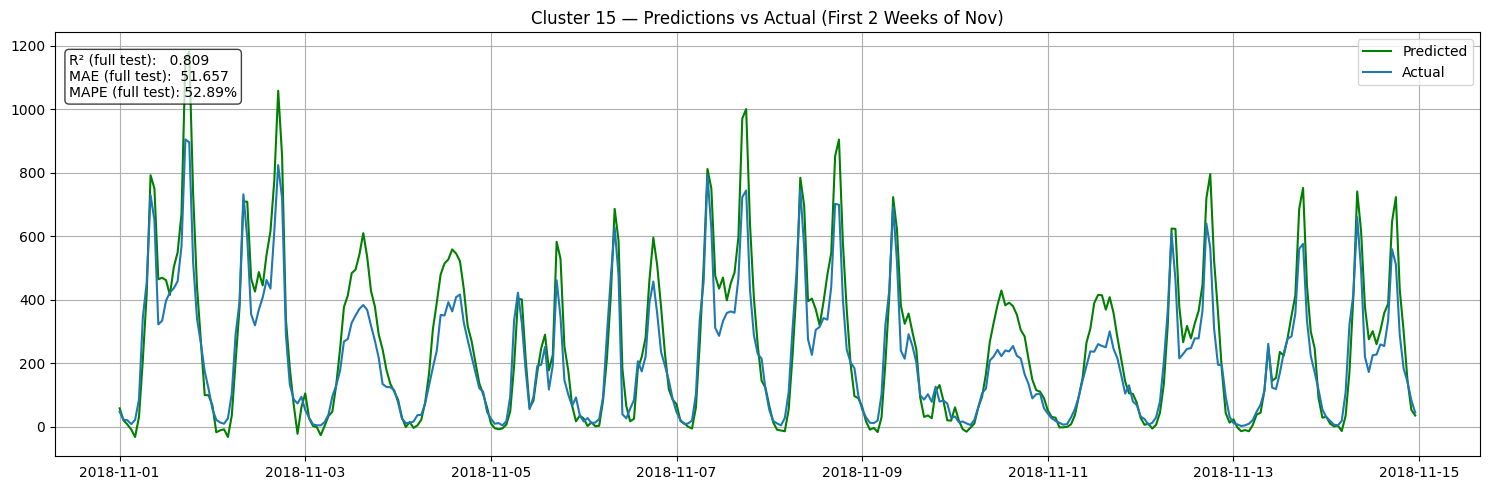

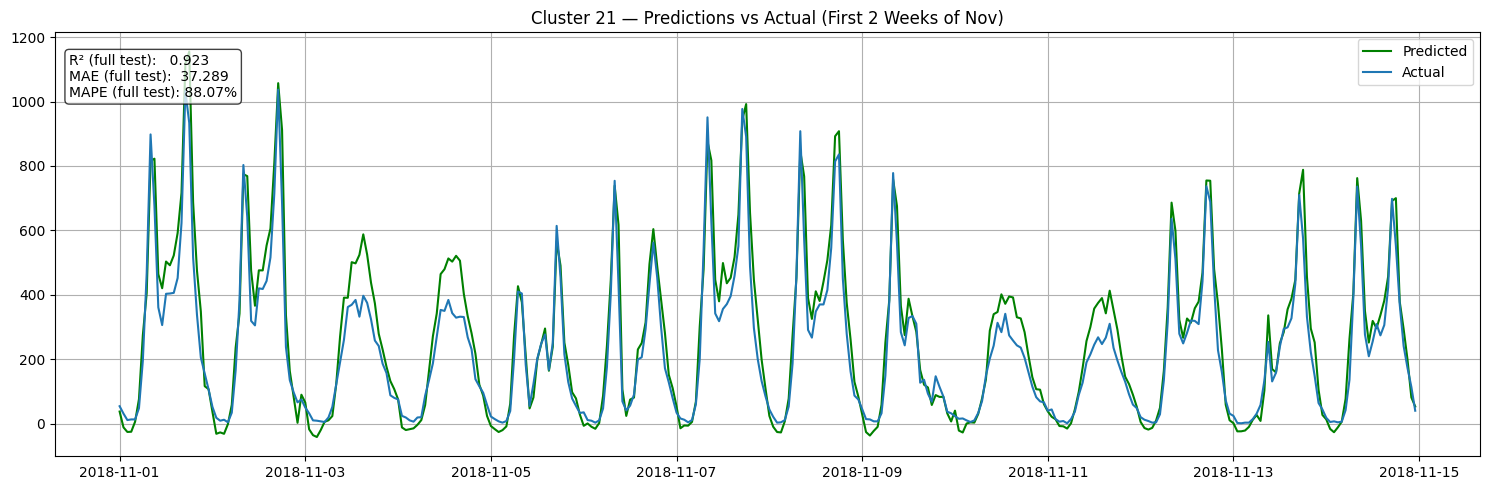

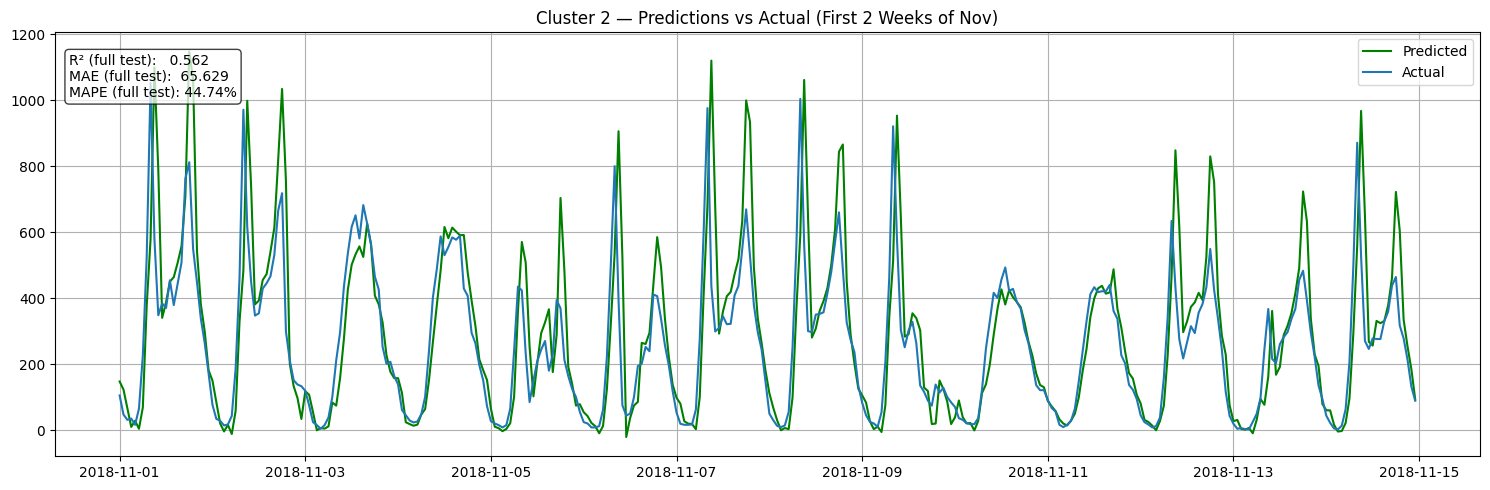

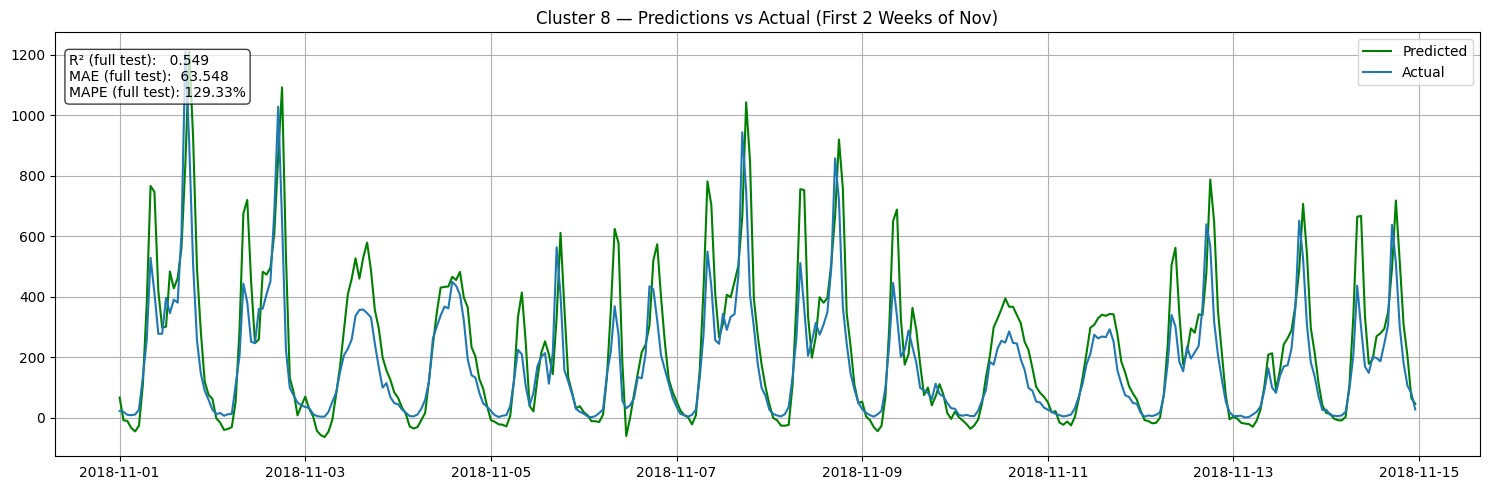

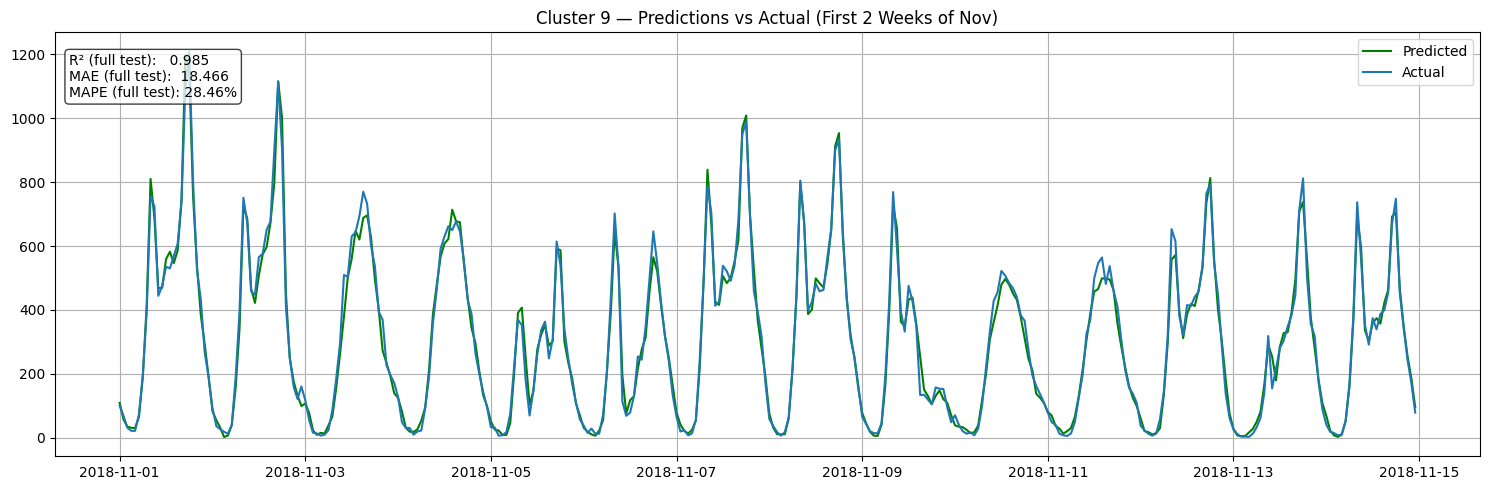

In [94]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# MAPE helper
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# ------------------------------------------------------
# 1) Time window for first two weeks of November test set
# ------------------------------------------------------
start_date = pd.Timestamp("2018-11-01 00:00:00")
end_date   = start_date + pd.Timedelta(days=14)


# ------------------------------------------------------
# 2) Loop through clusters and plot
# ------------------------------------------------------
for cluster in clusters:

    # Entire test set for this cluster
    X_test_full = pickup_test.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_test_full = pickup_test.xs(cluster, level="start_cluster")["count"]

    # Predict on the entire test set
    model = lasso_models[cluster]
    y_pred_full = model.predict(X_test_full)

    # ---------------------------
    # Full test-set metrics
    # ---------------------------
    r2  = r2_score(y_test_full, y_pred_full)
    mae = mean_absolute_error(y_test_full, y_pred_full)
    mape_val = mape(y_test_full, y_pred_full)

    metrics = [
        f"R² (full test):   {r2:.3f}",
        f"MAE (full test):  {mae:.3f}",
        f"MAPE (full test): {mape_val:.2f}%"
    ]

    # ---------------------------
    # First 2 weeks subset for plotting
    # ---------------------------
    mask = (X_test_full.index >= start_date) & (X_test_full.index < end_date)
    
    y_plot = y_test_full.loc[mask]
    y_pred_plot = pd.Series(y_pred_full, index=y_test_full.index).loc[mask]

    # ---------------------------
    # Plot only the 2-week period
    # ---------------------------
    plotprediction(
        series=y_plot,
        pred_series=y_pred_plot,
        metrics=metrics,                # <-- full test metrics
        labels=["Actual", "Predicted"],
        x_axis=y_plot.index,
        title=f"Cluster {cluster} — Predictions vs Actual (First 2 Weeks of Nov)"
    )

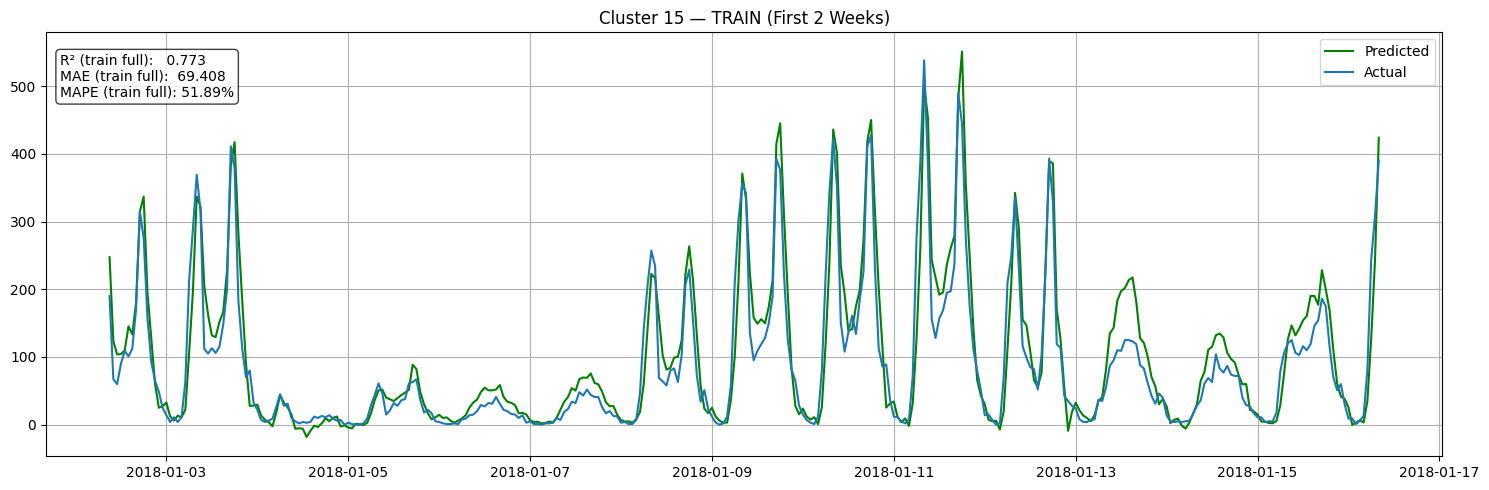

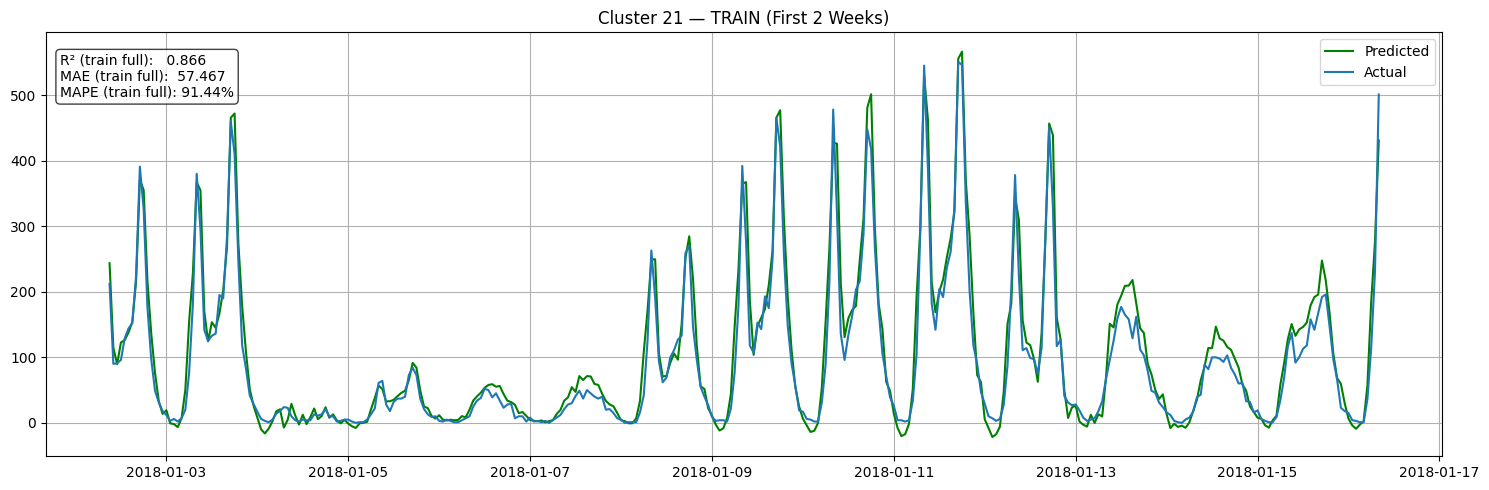

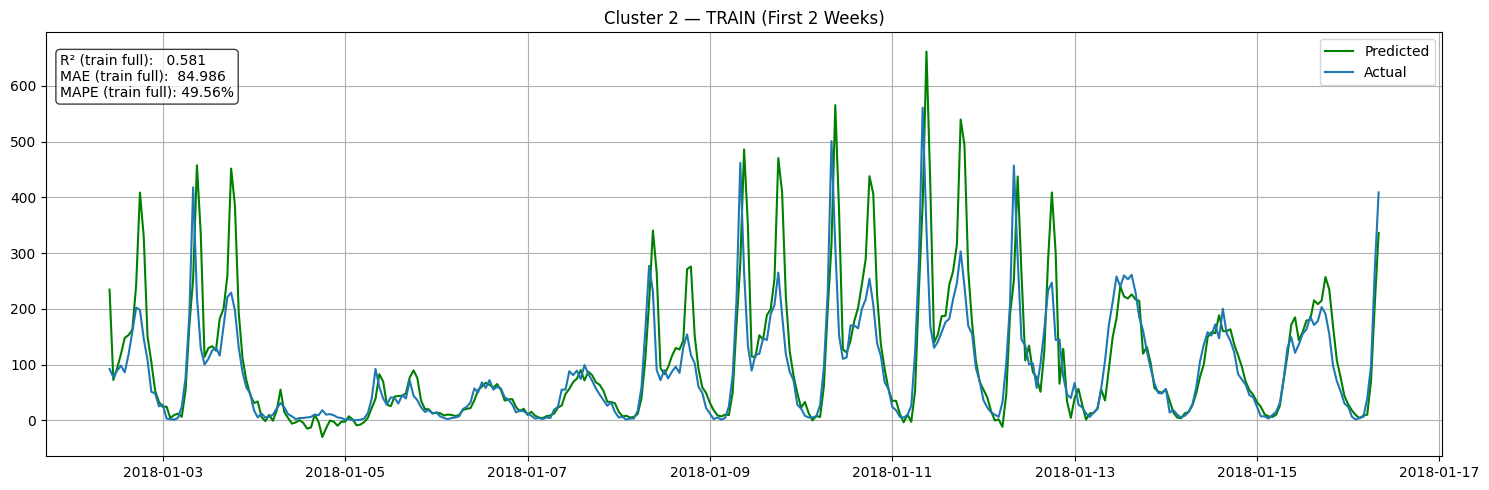

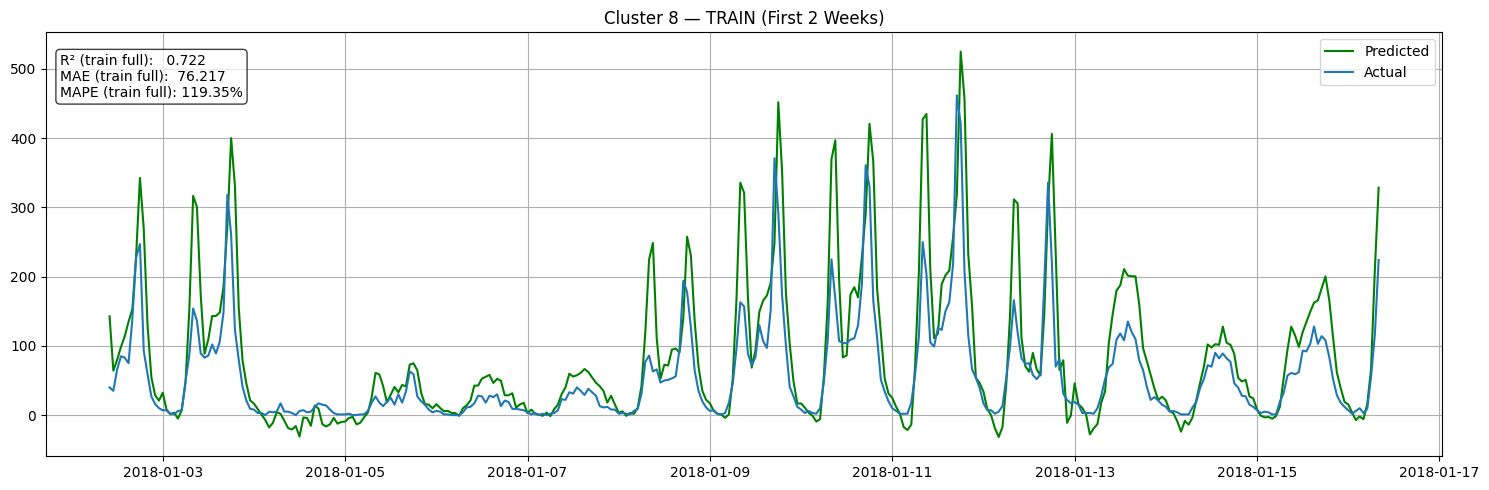

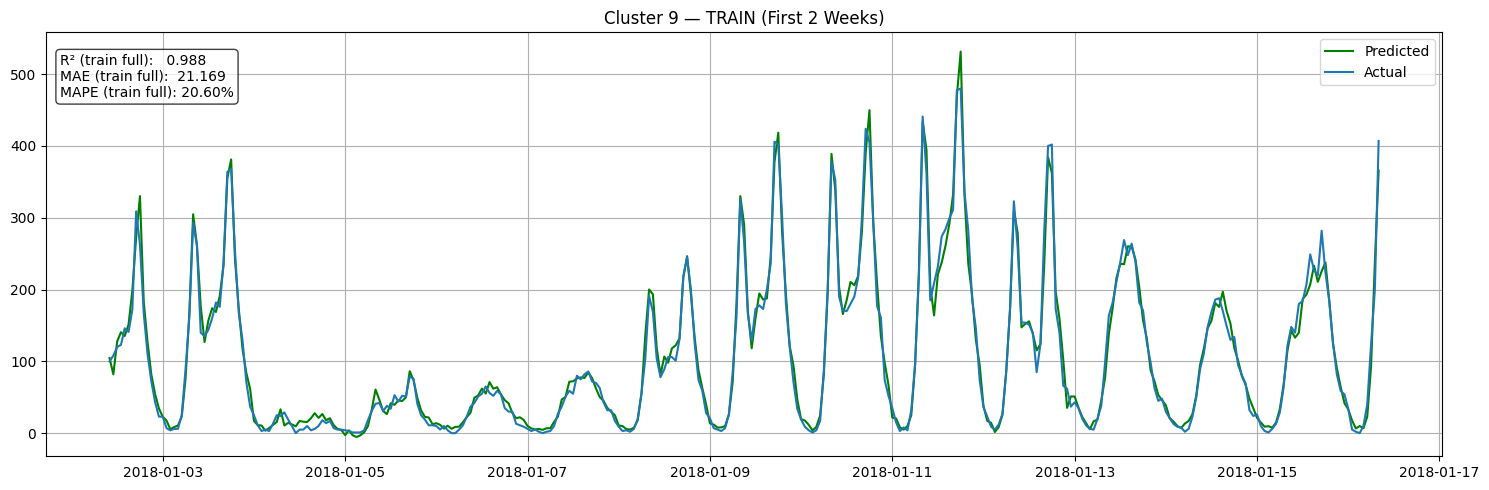

In [95]:
# The same but for the train set



# ------------------------------------------------------
# 1) Time window: first two weeks of the TRAIN set
# ------------------------------------------------------
train_start_date = pickup_train.index.get_level_values("timestamp").min()
train_end_date   = train_start_date + pd.Timedelta(days=14)


# ------------------------------------------------------
# 2) Loop through clusters — TRAIN reference plots
# ------------------------------------------------------
for cluster in clusters:

    # Entire TRAIN set for this cluster
    X_train_full = pickup_train.xs(cluster, level="start_cluster").drop(columns=["count"])
    y_train_full = pickup_train.xs(cluster, level="start_cluster")["count"]

    # Predict on entire TRAIN set
    model = lasso_models[cluster]
    y_pred_train_full = model.predict(X_train_full)

    # ---------------------------
    # Full train-set metrics
    # ---------------------------
    r2_train  = r2_score(y_train_full, y_pred_train_full)
    mae_train = mean_absolute_error(y_train_full, y_pred_train_full)
    mape_train = mape(y_train_full, y_pred_train_full)

    metrics = [
        f"R² (train full):   {r2_train:.3f}",
        f"MAE (train full):  {mae_train:.3f}",
        f"MAPE (train full): {mape_train:.2f}%"
    ]

    # ---------------------------
    # First 2 weeks subset for plotting
    # ---------------------------
    mask = (X_train_full.index >= train_start_date) & (X_train_full.index < train_end_date)

    y_plot = y_train_full.loc[mask]
    y_pred_plot = pd.Series(y_pred_train_full, index=y_train_full.index).loc[mask]

    # ---------------------------
    # Plot only the 2-week period
    # ---------------------------
    plotprediction(
        series=y_plot,
        pred_series=y_pred_plot,
        metrics=metrics,       # <-- full train metrics added
        labels=["Actual", "Predicted"],
        x_axis=y_plot.index,
        title=f"Cluster {cluster} — TRAIN (First 2 Weeks)"
    )

In [96]:
!pip install lightgbm

In [97]:
# Gradient Boosting with LightGBM for the pickup data


import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

# Dictionary to store models and predictions
lgb_models = {}
lgb_predictions_test = {}
lgb_predictions_train = {}
lgb_metrics = {}

clusters = sorted(pickup_train.index.get_level_values("start_cluster").unique())

feature_cols = [c for c in pickup_train.columns if c != "count"]

for cluster in clusters:
    print(f"Training LightGBM for cluster {cluster}...")
    
    # Extract cluster data
    train_df = pickup_train.xs(cluster, level="start_cluster")
    test_df  = pickup_test.xs(cluster, level="start_cluster")
    
    X_train = train_df[feature_cols]
    y_train = train_df["count"]
    
    X_test = test_df[feature_cols]
    y_test = test_df["count"]
    
    # LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=50,
        random_state=42
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    
    # Store everything
    lgb_models[cluster] = model
    lgb_predictions_train[cluster] = pred_train
    lgb_predictions_test[cluster]  = pred_test
    
    # Metrics
    lgb_metrics[cluster] = {
        "r2_train": r2_score(y_train, pred_train),
        "r2_test":  r2_score(y_test,  pred_test),
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test":  mean_absolute_error(y_test,  pred_test),
        "mape_train": (np.abs((y_train - pred_train) / y_train.replace(0, np.nan))).mean(),
        "mape_test":  (np.abs((y_test - pred_test) / y_test.replace(0, np.nan))).mean(),
    }


Training LightGBM for cluster 2...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 260.813963
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 203.137841
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGB

In [98]:
# Summary 

metrics_df = pd.DataFrame(lgb_metrics).T
metrics_df


,r2_train,r2_test,mae_train,mae_test,mape_train,mape_test
2,0.997062,0.961508,8.317437,22.246931,0.120184,0.232915
8,0.998827,0.955970,5.659936,17.732288,0.149018,0.244545
9,0.998850,0.981525,7.079439,19.652618,0.101150,0.229483
15,0.998395,0.982246,6.303182,15.142980,0.111953,0.215478
21,0.999070,0.986574,5.175082,14.668238,0.113741,0.186917


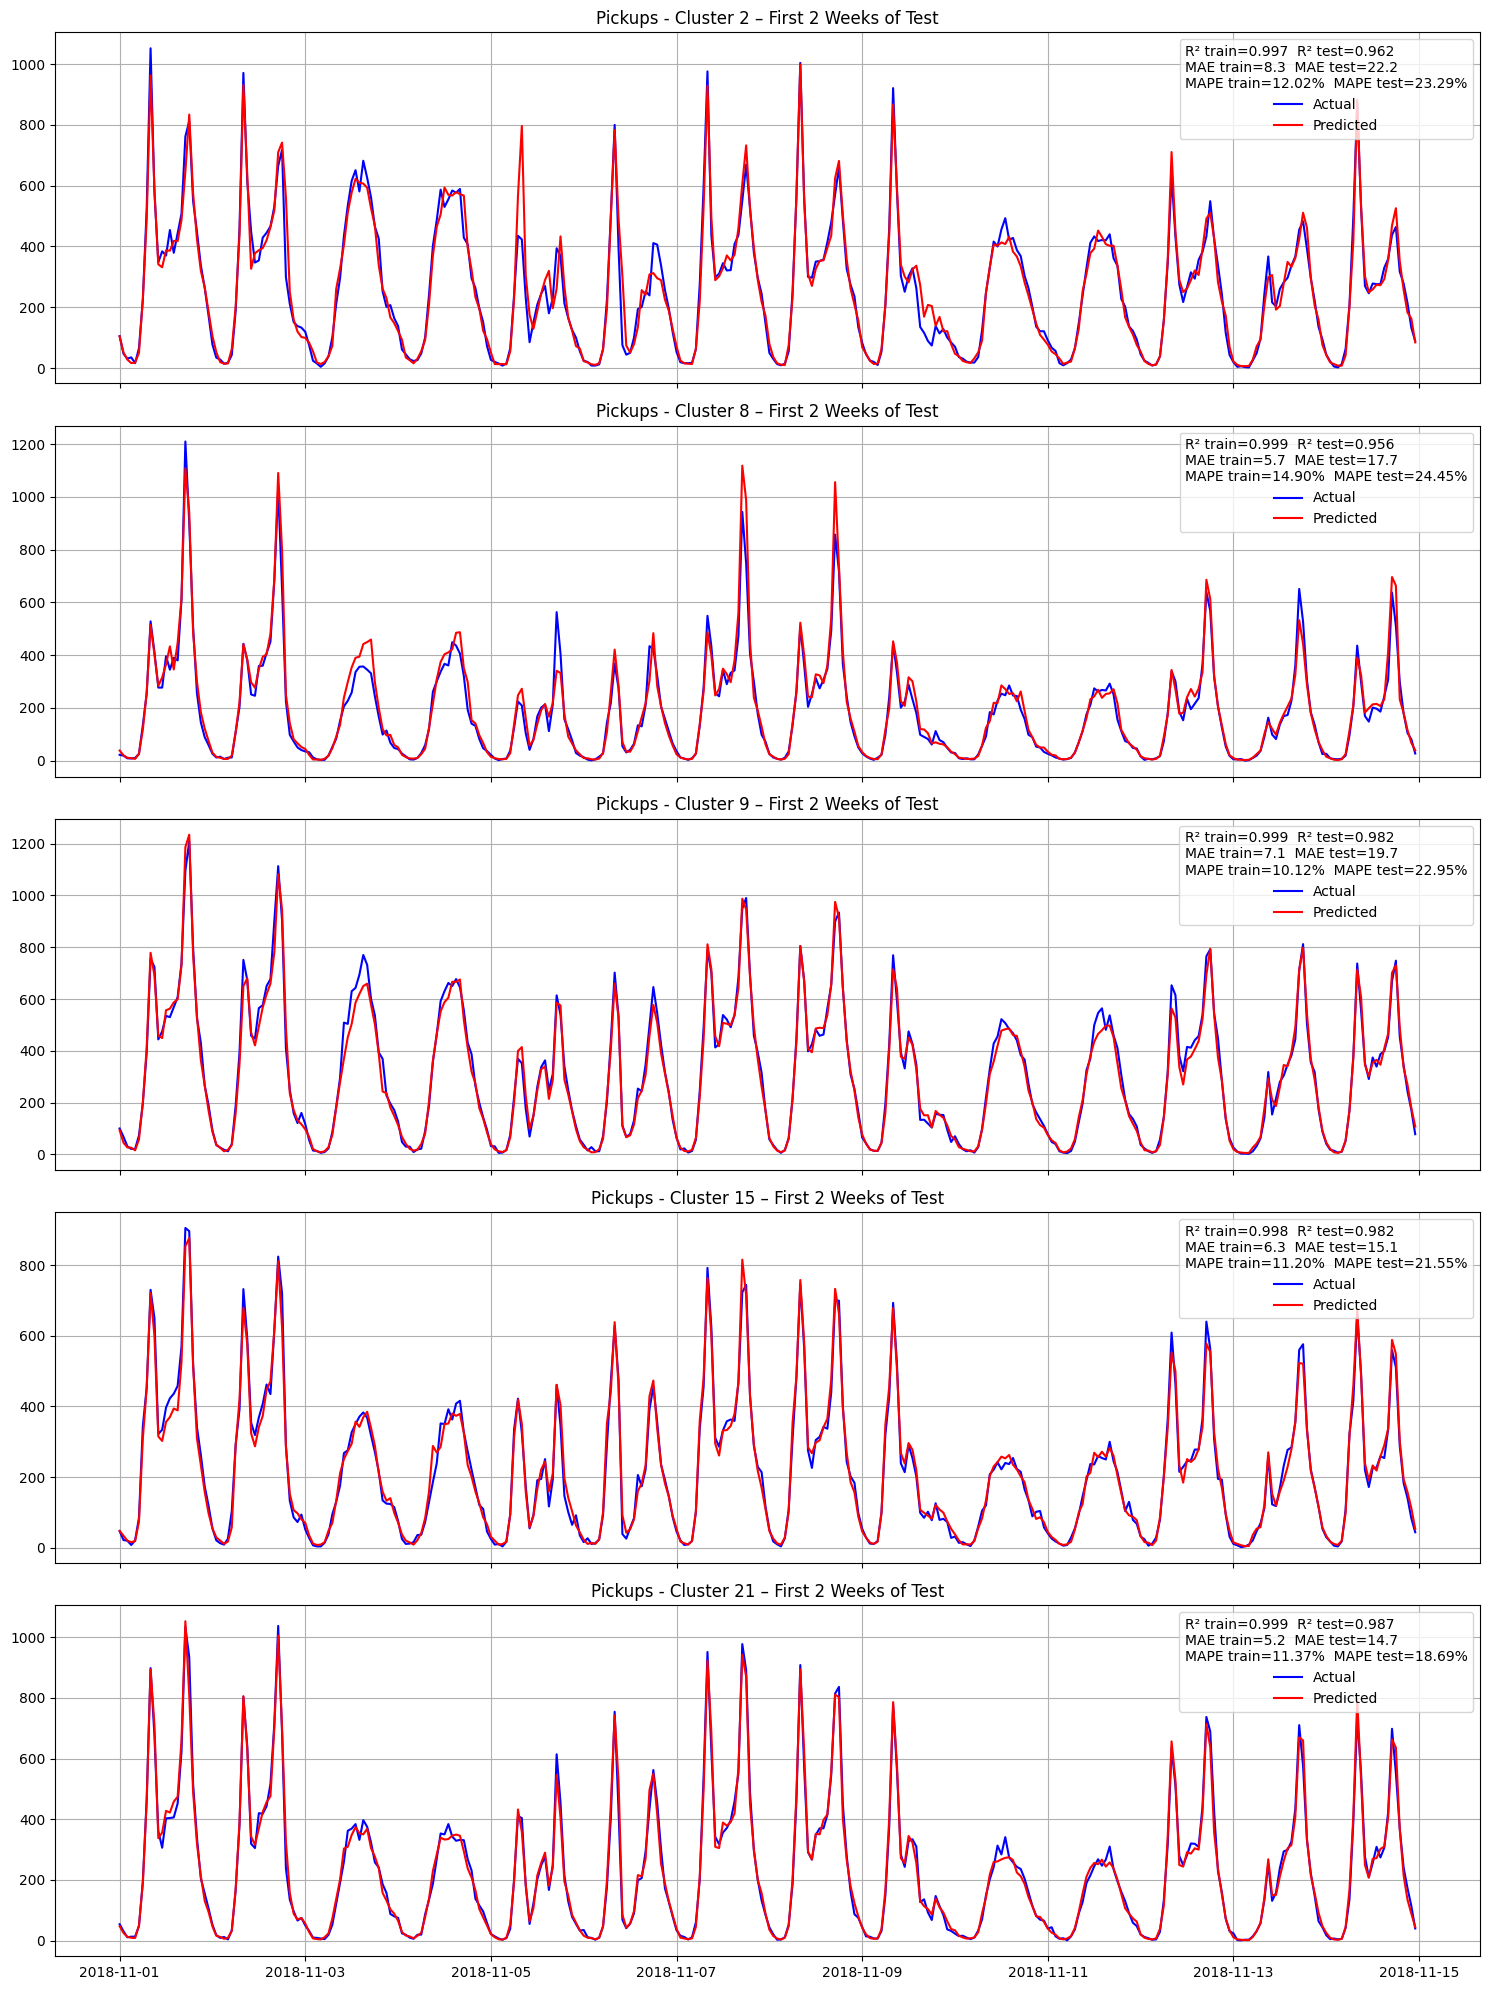

In [99]:
# First 2-week window
start_date = pickup_test.index.get_level_values('timestamp').min()
end_date = start_date + pd.Timedelta(days=14)

fig, axes = plt.subplots(len(clusters), 1, figsize=(15, 4*len(clusters)), sharex=True)

for i, cluster in enumerate(clusters):
    
    df_test = pickup_test.xs(cluster, level='start_cluster')
    df_two_weeks = df_test.loc[(df_test.index >= start_date) & (df_test.index < end_date)]
    
    pred_series = pd.Series(
        lgb_predictions_test[cluster],
        index=df_test.index
    ).loc[df_two_weeks.index]
    
    axes[i].plot(df_two_weeks.index, df_two_weeks['count'], label="Actual", color="blue")
    axes[i].plot(df_two_weeks.index, pred_series, label="Predicted", color="red")
    
    # Add metrics in legend
    m = lgb_metrics[cluster]
    axes[i].legend(title=(
        f"R² train={m['r2_train']:.3f}  R² test={m['r2_test']:.3f}\n"
        f"MAE train={m['mae_train']:.1f}  MAE test={m['mae_test']:.1f}\n"
        f"MAPE train={m['mape_train']:.2%}  MAPE test={m['mape_test']:.2%}"
    ))
    
    axes[i].set_title(f"Pickups - Cluster {cluster} – First 2 Weeks of Test")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


For dropoffs

In [100]:
# Dictionary to store models and predictions
lgb_models_drop = {}
lgb_predictions_test_drop = {}
lgb_predictions_train_drop = {}
lgb_metrics_drop = {}

clusters = sorted(dropoff_train.index.get_level_values("end_cluster").unique())

feature_cols = [c for c in dropoff_train.columns if c != "count"]

for cluster in clusters:
    print(f"Training LightGBM for cluster {cluster}...")
    
    # Extract cluster data
    train_df = dropoff_train.xs(cluster, level="end_cluster")
    test_df  = dropoff_test.xs(cluster, level="end_cluster")
    
    X_train = train_df[feature_cols]
    y_train = train_df["count"]
    
    X_test = test_df[feature_cols]
    y_test = test_df["count"]
    
    # LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=50,
        random_state=42
    )
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    
    # Store everything
    lgb_models_drop[cluster] = model
    lgb_predictions_train_drop[cluster] = pred_train
    lgb_predictions_test_drop[cluster]  = pred_test
    
    # Metrics
    lgb_metrics_drop[cluster] = {
        "r2_train": r2_score(y_train, pred_train),
        "r2_test":  r2_score(y_test,  pred_test),
        "mae_train": mean_absolute_error(y_train, pred_train),
        "mae_test":  mean_absolute_error(y_test,  pred_test),
        "mape_train": (np.abs((y_train - pred_train) / y_train.replace(0, np.nan))).mean(),
        "mape_test":  (np.abs((y_test - pred_test) / y_test.replace(0, np.nan))).mean(),
    }


Training LightGBM for cluster 2...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 262.815340
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGBM] [Info] Number of data points in the train set: 7262, number of used features: 176
[LightGBM] [Info] Start training from score 206.888736
Training LightGBM for cluster 8...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42878
[LightGB

In [101]:
# Summary 

metrics_df_drop = pd.DataFrame(lgb_metrics).T
metrics_df_drop

,r2_train,r2_test,mae_train,mae_test,mape_train,mape_test
2,0.997062,0.961508,8.317437,22.246931,0.120184,0.232915
8,0.998827,0.955970,5.659936,17.732288,0.149018,0.244545
9,0.998850,0.981525,7.079439,19.652618,0.101150,0.229483
15,0.998395,0.982246,6.303182,15.142980,0.111953,0.215478
21,0.999070,0.986574,5.175082,14.668238,0.113741,0.186917


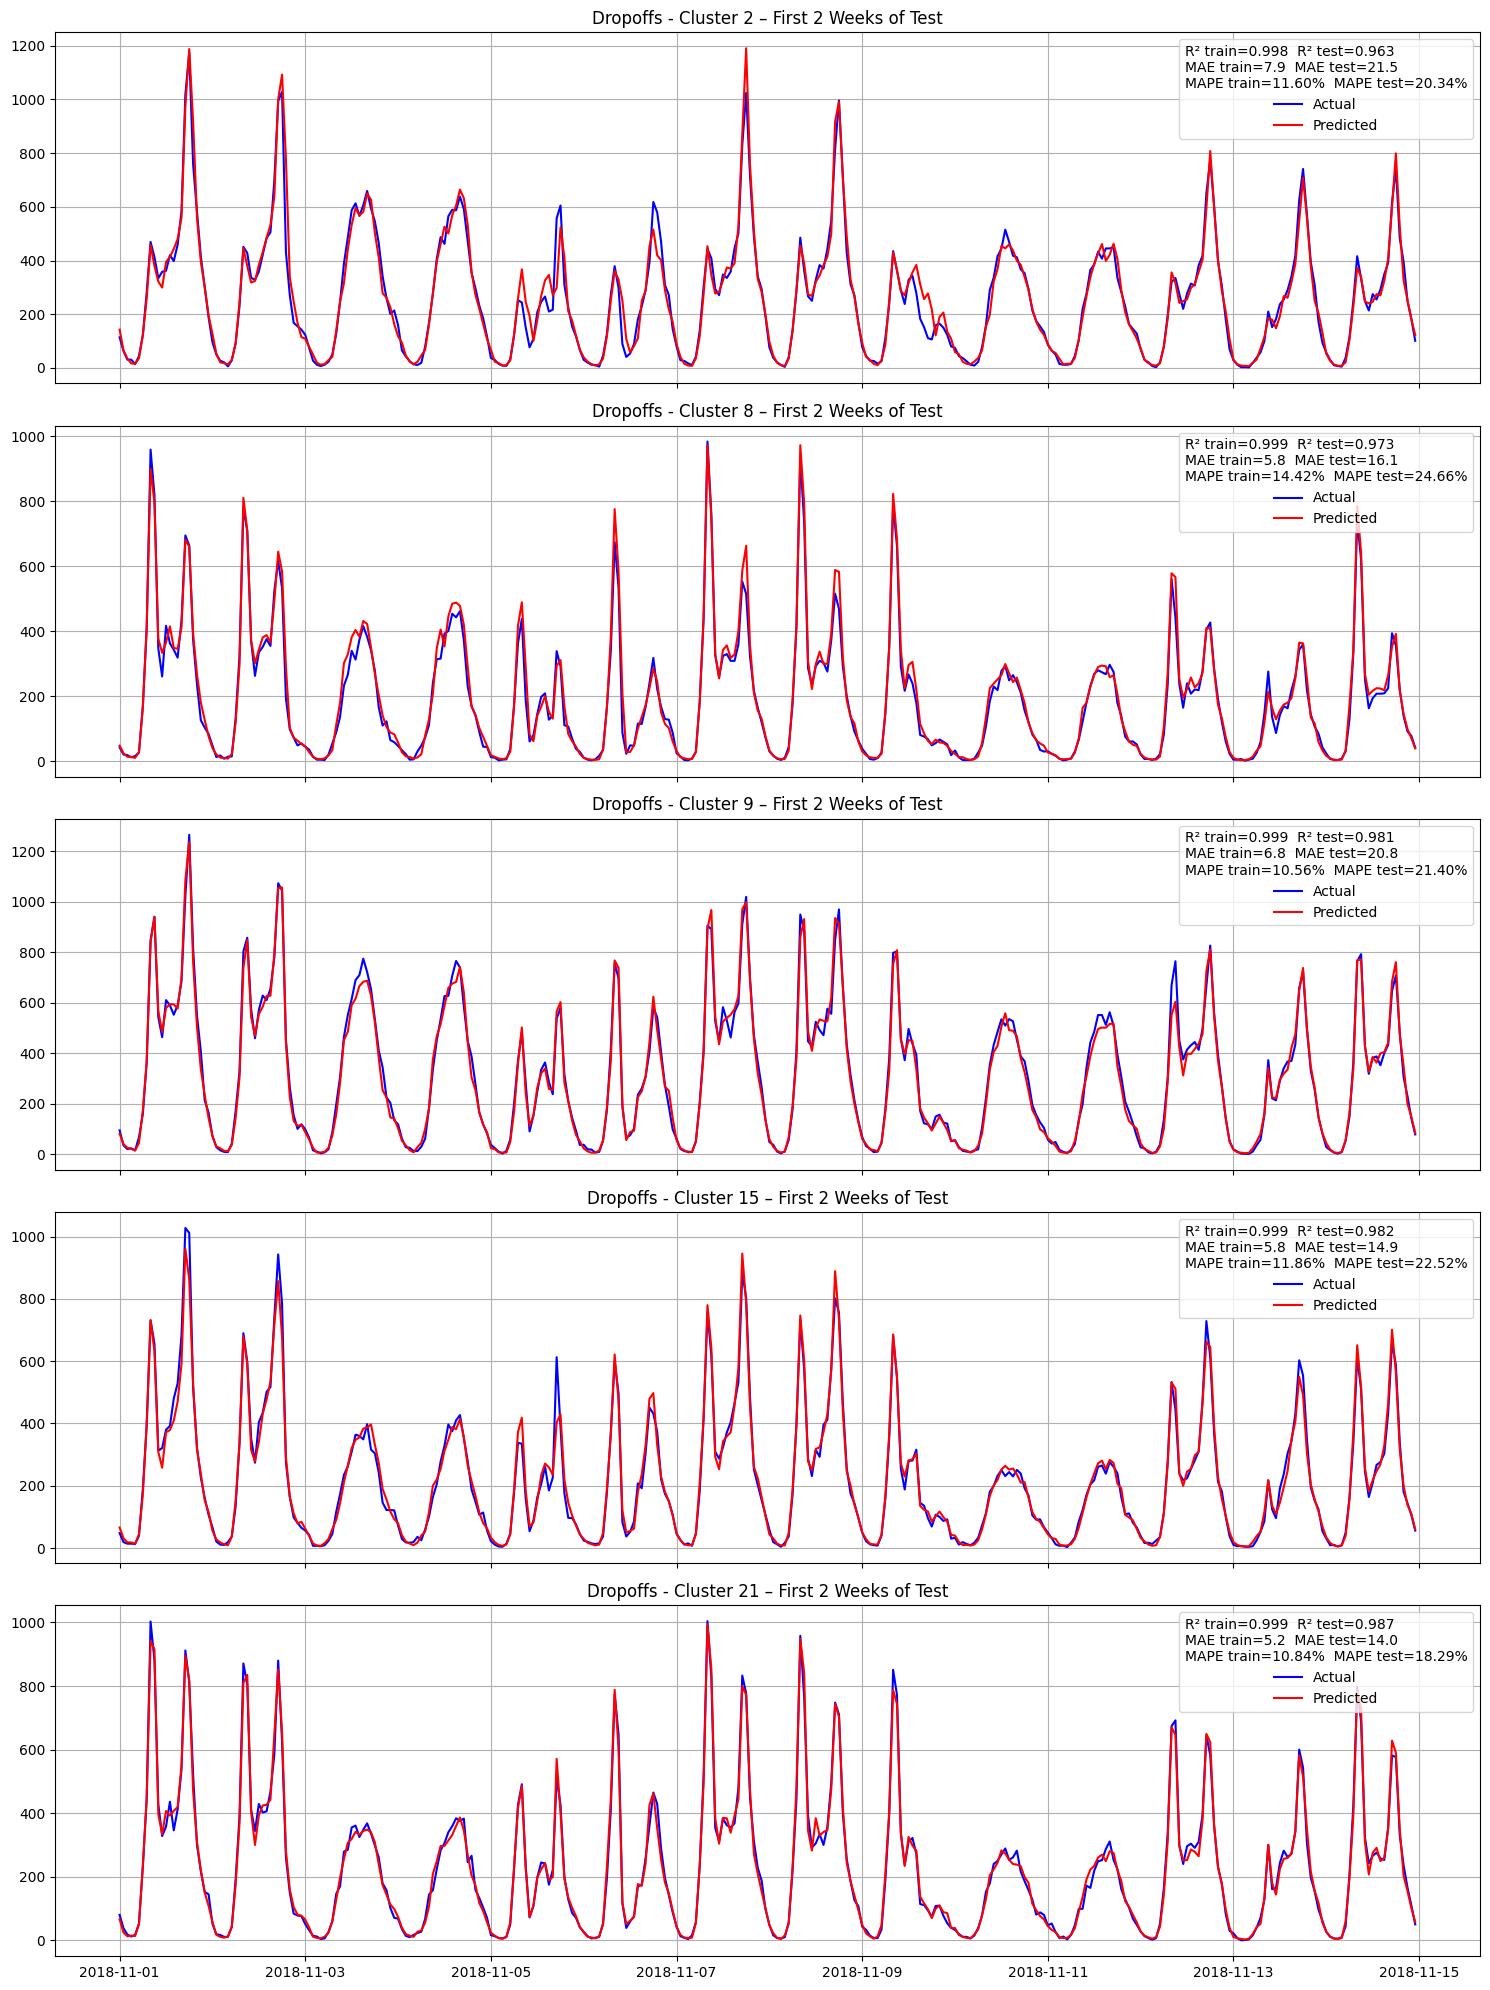

In [102]:
# First 2-week window
start_date = dropoff_test.index.get_level_values('timestamp').min()
end_date = start_date + pd.Timedelta(days=14)

fig, axes = plt.subplots(len(clusters), 1, figsize=(15, 4*len(clusters)), sharex=True)

for i, cluster in enumerate(clusters):
    
    df_test = dropoff_test.xs(cluster, level='end_cluster')
    df_two_weeks = df_test.loc[(df_test.index >= start_date) & (df_test.index < end_date)]
    
    pred_series = pd.Series(
        lgb_predictions_test_drop[cluster],
        index=df_test.index
    ).loc[df_two_weeks.index]
    
    axes[i].plot(df_two_weeks.index, df_two_weeks['count'], label="Actual", color="blue")
    axes[i].plot(df_two_weeks.index, pred_series, label="Predicted", color="red")
    
    # Add metrics in legend
    m = lgb_metrics_drop[cluster]
    axes[i].legend(title=(
        f"R² train={m['r2_train']:.3f}  R² test={m['r2_test']:.3f}\n"
        f"MAE train={m['mae_train']:.1f}  MAE test={m['mae_test']:.1f}\n"
        f"MAPE train={m['mape_train']:.2%}  MAPE test={m['mape_test']:.2%}"
    ))
    
    axes[i].set_title(f"Dropoffs - Cluster {cluster} – First 2 Weeks of Test")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Task 3: Calculate required bikes per cluster to avoid shortages

Use cumulative net flow (dropoffs - pickups) to determine minimum bikes needed at start of each day.

## Part 2: Exploratory Analysis - Seasonal and Periodic Trends

### Research Question: Are there periodic and seasonal trends (e.g., winter, summer)?

The seasons in NYC are:
- **Winter**: Dec - Feb
- **Spring**: March - May
- **Summer**: June - August
- **Fall**: September - November

In [103]:
# Reload original data for exploratory analysis
f_explore = pd.read_csv("../data/Trips_2018.csv")

# Data preprocessing
f_explore.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f_explore['starttime'] = pd.to_datetime(f_explore['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f_explore = f_explore.set_index('starttime')
f_explore['stoptime'] = pd.to_datetime(f_explore['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f_explore['usertype'] = pd.Categorical(f_explore['usertype'])
f_explore['gender'] = pd.Categorical(f_explore['gender'])
f_explore['start_station_id'] = pd.Categorical(f_explore['start_station_id'])
f_explore['end_station_id'] = pd.Categorical(f_explore['end_station_id'])
f_explore = f_explore.dropna()

print("Data loaded for exploratory analysis.")

KeyboardInterrupt: 

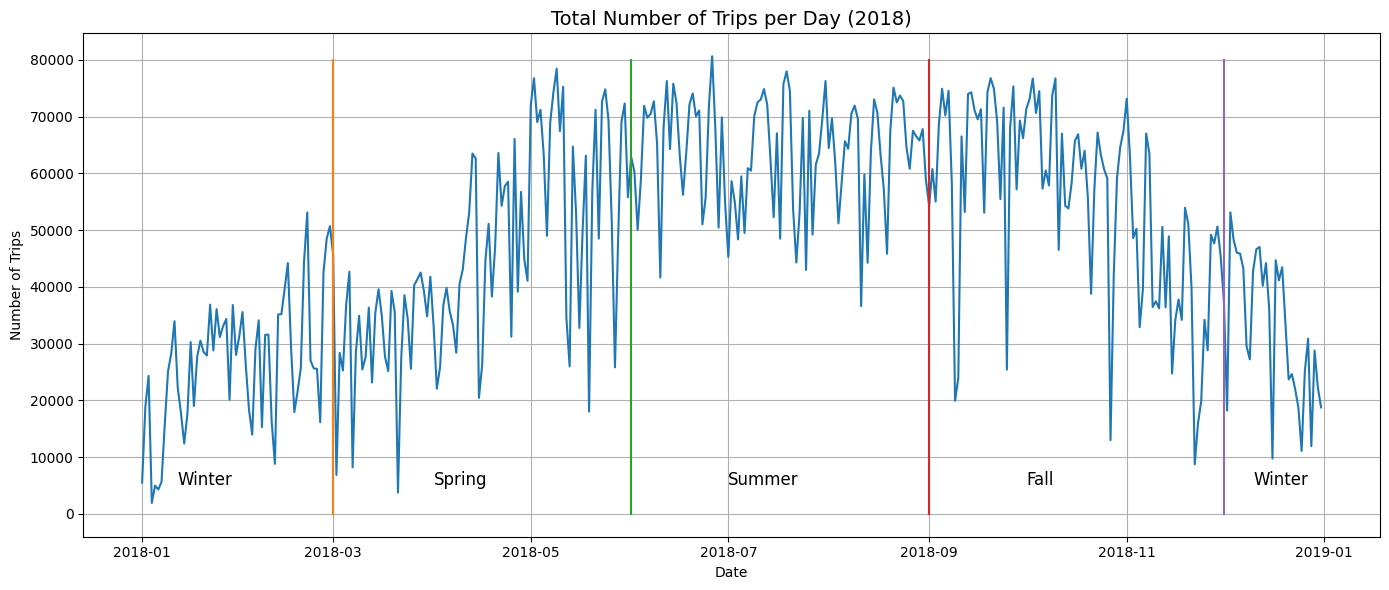


Observation: Bikes are more frequently used during summer months. Non-stationary mean and variance detected.


In [ ]:
# Count how many trips start on each day
daily_counts = f_explore.resample('D').size()  # 'D' = daily frequency

# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_counts.index, daily_counts.values, linewidth=1.5)
plt.title("Total Number of Trips per Day (2018)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()

plt.annotate('Winter', xy=(pd.Timestamp('2018-01-12'), 5000), xytext=(pd.Timestamp('2018-01-12'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-03-01'), pd.Timestamp('2018-03-01')], [0, 80000])
plt.annotate('Spring', xy=(pd.Timestamp('2018-04-01'), 5000), xytext=(pd.Timestamp('2018-04-01'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-06-01'), pd.Timestamp('2018-06-01')], [0, 80000])
plt.annotate('Summer', xy=(pd.Timestamp('2018-07-01'), 5000), xytext=(pd.Timestamp('2018-07-01'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-09-01'), pd.Timestamp('2018-09-01')], [0, 80000])
plt.annotate('Fall', xy=(pd.Timestamp('2018-10-01'), 5000), xytext=(pd.Timestamp('2018-10-01'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-01')], [0, 80000])
plt.annotate('Winter', xy=(pd.Timestamp('2018-12-10'), 5000), xytext=(pd.Timestamp('2018-12-10'), 5000), fontsize=12)
plt.show()

We see a obvious trend

Bikes are more frequently used during the summer months

We have non-stationary mean and non-stationary variance

## Summary and Conclusions

### Task 1: Clustering
- Successfully clustered 22 spatial zones in NYC using K-means
- Focused on 5 Manhattan clusters for detailed analysis

### Task 2: Prediction
- Built gradient boosting models to predict 24-hour ahead demand
- Separate models for pickups and dropoffs per cluster
- Features: 24-hour lags, weekly lag, day-of-week, hour
- Training: Jan-Oct 2018 | Testing: Nov-Dec 2018

### Task 3: Bike Repositioning
- Calculated required initial bikes per cluster per day
- Based on maximum cumulative deficit in hourly demand
- Ensures no shortage of bikes throughout the day

### Key Insights from Exploratory Analysis
- **Strong seasonal variation**: Summer usage >> Winter usage
- **Clear daily patterns**: Rush hours (8-9am, 5-6pm) show peak demand
- **Model performance**: Varies by cluster (Manhattan clusters show good predictions)
- **Repositioning needs**: Vary significantly by day (weekends vs weekdays)